<center>
    <h1>Assignment 2 - Question Answering with Transformers on CoQA</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it, enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>



---



Assignment description: see `Assignment.ipynb`.

In this notebook the QA task is addressed.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `utils` folder.

In [1]:
import json
import numpy as np
import pandas as pd
import torch

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [3]:
# Settings for reproducibility
from utils.seeder import set_random_seed

set_random_seed(42)

# [Task 1] Remove unaswerable QA pairs

## 1.1 Dataset download

The dataset is downloaded and saved in the `coqua` folder using the snippet of code provided in `Assignment.ipynb`.

In [4]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [5]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

## 1.2 Dataframe Creation

The train and test dataframes (`train_df` and `test_df`) are built. Each row contains information about a specific question and the corresponding answer along with their chronological collocation (`turn_id`) in the conversation. Furthermore informations about the passage containing the context and the history of previous questions and answers of the relative conversation is contained.

In [6]:
from utils.dataframe_builder import get_dataframe

train_df = get_dataframe(os.path.join('coqa', 'train.json'))
test_df = get_dataframe(os.path.join('coqa', 'test.json'))


## 1.3 Data Inspection

The heads of the train and test dataframes are shown below along with their shapes.

In [7]:
print(f'Train dataframe shape: {train_df.shape}')
train_df.head()

Train dataframe shape: (108647, 15)


,source,id,filename,story,name,question_input_text,question_turn_id,question_bad_turn,answer_span_start,answer_span_end,answer_span_text,answer_input_text,answer_turn_id,answer_bad_turn,history
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,When was the Vat formally opened?,1,NaN,151,179,Formally established in 1475,It was formally established in 1475,1,NaN,[]
1,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,what is the library for?,2,NaN,454,494,he Vatican Library is a research library,research,2,NaN,"[When was the Vat formally opened?, It was for..."
2,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,for what subjects?,3,NaN,457,511,Vatican Library is a research library for hist...,"history, and law",3,NaN,"[When was the Vat formally opened?, It was for..."
3,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,and?,4,NaN,457,545,Vatican Library is a research library for hist...,"philosophy, science and theology",4,NaN,"[When was the Vat formally opened?, It was for..."
4,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,what was started in 2014?,5,NaN,769,879,"March 2014, the Vatican Library began an initi...",a project,5,NaN,"[When was the Vat formally opened?, It was for..."


In [8]:
print(f'Test dataframe shape: {test_df.shape}')
test_df.head()

Test dataframe shape: (7983, 14)


,source,id,filename,story,additional_answers,name,question_input_text,question_turn_id,answer_span_start,answer_span_end,answer_span_text,answer_input_text,answer_turn_id,history
0,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,What color was Cotton?,1,59,93,a little white kitten named Cotton,white,1,[]
1,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,Where did she live?,2,18,80,"in a barn near a farm house, there lived a lit...",in a barn,2,"[What color was Cotton?, white]"
2,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,Did she live alone?,3,196,215,Cotton wasn't alone,no,3,"[What color was Cotton?, white, Where did she ..."
3,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,Who did she live with?,4,281,315,with her mommy and 5 other sisters,with her mommy and 5 sisters,4,"[What color was Cotton?, white, Where did she ..."
4,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,What color were her sisters?,5,428,490,her sisters were all orange with beautiful whi...,orange and white,5,"[What color was Cotton?, white, Where did she ..."


We can observe that the training dataframe contains $15$ different features, while the test dataframe has just $14$. In particular the train dataframe includes the additional features `question_bad_turn` and `answer_bad_turn`. With a quick inspection of the dataframe's head it can be observed that they include `NaN` values. Since the task requires to remove solely unanswerable question-answer pairs, not mentioning the handling of "bad turn", these two features are dropped.

On the other hand the test dataframe contains the extra feature `additional_answers`, which can be removed as expressed in the specifications of the assignment.

In [9]:
# Drop non-matching features

train_df.drop(['question_bad_turn', 'answer_bad_turn'], axis=1, inplace=True)
test_df.drop('additional_answers', axis=1, inplace=True)

In addition the features `name` and `filename` are removed since they are considered useless for the task.

In [10]:
# Drop useless columns (`name`, `filename`)

train_df.drop(['name', 'filename'], axis=1, inplace=True)
test_df.drop(['name', 'filename'], axis=1, inplace=True)

Next, by inspecting the `question_turn_id` and `answer_turn_id` it can be noticed that they are equivalent, since they refer to the same question-answer pair, hence they can be merged in a single feature (`turn_id`).

In [11]:
# Assert that the turn ids of the questions are the same as the respective answers

assert train_df['question_turn_id'].equals(train_df['answer_turn_id']), \
    'Question and answer turn ids are different in the train dataset'
    
assert test_df['question_turn_id'].equals(test_df['answer_turn_id']), \
    'Question and answer turn ids are different in the test dataset'

In [12]:
# Rename columns `question_turn_id` and `answer_turn_id` into a singular `turn_id` column since they are equal
refactor_turn_id_columns = lambda df: \
    df.drop('question_turn_id', axis=1).rename(columns = {'answer_turn_id': 'turn_id'})
    
train_df = refactor_turn_id_columns(train_df)
test_df = refactor_turn_id_columns(test_df)

Finally the columns `answer_input_text` and `question_input_text` are renamed into `answer` and `question` respectively for simplicity.

In [13]:
# Rename columns `answer_input_text` and `question_input_text` into `answer` and `question` respectively
column_renames = {'answer_input_text': 'answer', 'question_input_text': 'question'}

train_df.rename(columns=column_renames, inplace=True)
test_df.rename(columns=column_renames, inplace=True)

The shapes of the dataframes now match on the column number and no Null values are present.

In [14]:
print(f'Train dataframe shape after the unwanted columns drop: {train_df.shape}')
print(f'Test dataframe shape after the unwanted column drop: {test_df.shape}')

Train dataframe shape after the unwanted columns drop: (108647, 10)
Test dataframe shape after the unwanted column drop: (7983, 10)


In [15]:
print(f'Null values in the train dataframe: {train_df.isna().sum().sum()}.')
print(f'Null values in the test dataframe: {test_df.isna().sum().sum()}.')

Null values in the train dataframe: 0.
Null values in the test dataframe: 0.


In [16]:
train_df.head()

,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,151,179,Formally established in 1475,It was formally established in 1475,1,[]
1,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",what is the library for?,454,494,he Vatican Library is a research library,research,2,"[When was the Vat formally opened?, It was for..."
2,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",for what subjects?,457,511,Vatican Library is a research library for hist...,"history, and law",3,"[When was the Vat formally opened?, It was for..."
3,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",and?,457,545,Vatican Library is a research library for hist...,"philosophy, science and theology",4,"[When was the Vat formally opened?, It was for..."
4,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,769,879,"March 2014, the Vatican Library began an initi...",a project,5,"[When was the Vat formally opened?, It was for..."


In [17]:
test_df.head()

,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",What color was Cotton?,59,93,a little white kitten named Cotton,white,1,[]
1,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Where did she live?,18,80,"in a barn near a farm house, there lived a lit...",in a barn,2,"[What color was Cotton?, white]"
2,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Did she live alone?,196,215,Cotton wasn't alone,no,3,"[What color was Cotton?, white, Where did she ..."
3,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Who did she live with?,281,315,with her mommy and 5 other sisters,with her mommy and 5 sisters,4,"[What color was Cotton?, white, Where did she ..."
4,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",What color were her sisters?,428,490,her sisters were all orange with beautiful whi...,orange and white,5,"[What color was Cotton?, white, Where did she ..."


## 1.3 Remove Unanswerable Question-Answer Pairs

As required by the task, the unanswerable question-answer pairs are removed from the dataset by dropping the rows of the dataframes where the feature `answer` is equal to "unknown".

In [18]:
# Delete rows with unknown answer

train_df.drop(train_df[train_df['answer'] == 'unknown'].index, inplace=True)
train_df.reset_index(drop=True, inplace=True)

test_df.drop(test_df[test_df['answer'] == 'unknown'].index, inplace=True)
test_df.reset_index(drop=True, inplace=True)


In [19]:
print(f'Train dataframe shape after the unanswerable question-answer pairs are removed: {train_df.shape}')
print(f'Test dataframe shape after the unanswerable question-answer pairs are removed: {test_df.shape}')

Train dataframe shape after the unanswerable question-answer pairs are removed: (107276, 10)
Test dataframe shape after the unanswerable question-answer pairs are removed: (7917, 10)


In the next cell it is asserted that the history was properly created for each Question-Answer pair.

In [20]:
def check_history(df: pd.DataFrame, dataframe_name: str = None):
    """Check that the history is properly built for each Question-Answer pair in each row of the dataframe.

    Parameters
    ----------
    df : DataFrame
        The dataframe on which the history is checked.
    dataframe_name : str, optional
        The name of the dataframe. Defaults to None.
    """
    prev_doc = None
    prev_hist = []
    prev_question = None
    prev_answer = None
    for d, h, q, a in zip(df['id'], df['history'], df['question'], df['answer']):
        if d != prev_doc:
            assert len(h) == 0, 'Error: Initial history of a new conversation is not empty!'
            prev_doc = d
            prev_hist = []
            prev_question = q
            prev_answer = a
        else:
            assert prev_hist + [prev_question, prev_answer] == h, 'Error: The history was not computed properly!'
            prev_question = q
            prev_answer = a
            prev_hist = h

    print(f'The history{f" of {dataframe_name} dataframe" if dataframe_name is not None else ""}', 
          'was properly built for each Question-Answer pair.')

check_history(train_df, 'train')
check_history(test_df, 'test')

The history of train dataframe was properly built for each Question-Answer pair.
The history of test dataframe was properly built for each Question-Answer pair.


## 1.4 Data Analysis

In this section some interesting analyses on the training set are carried out.

In [21]:
# Group dataframe by `id`
grouped_train_df = train_df.groupby(by=['id'])

In [22]:
print(f'Number of train passages: {len(grouped_train_df)}')

Number of train passages: 7193


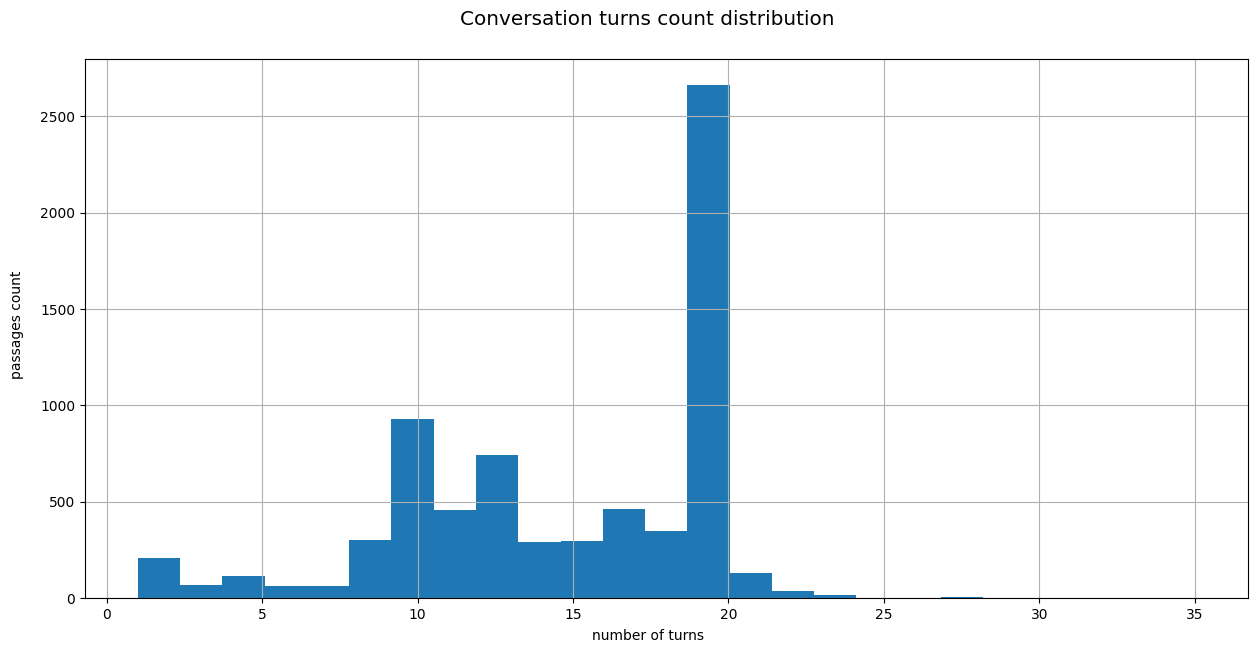

In [23]:
from utils.dataset_analisys import *
plot_converstion_length_distribution(grouped_train_df)

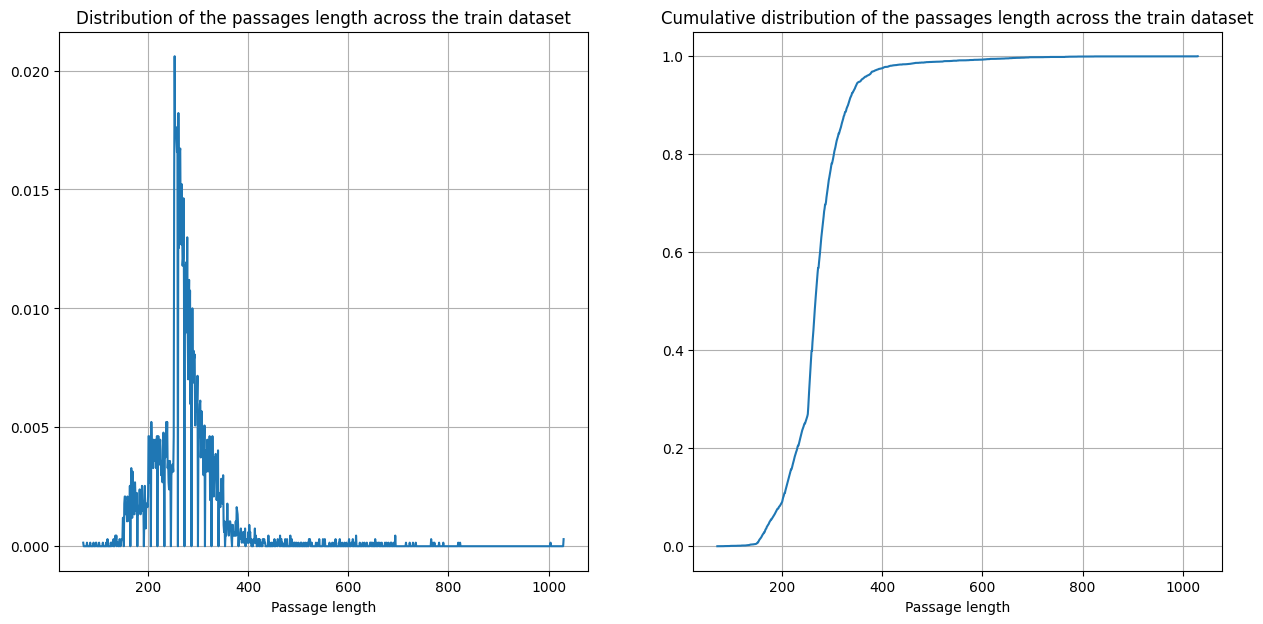

In [24]:
plot_passage_length_analysis(grouped_train_df.story.unique())

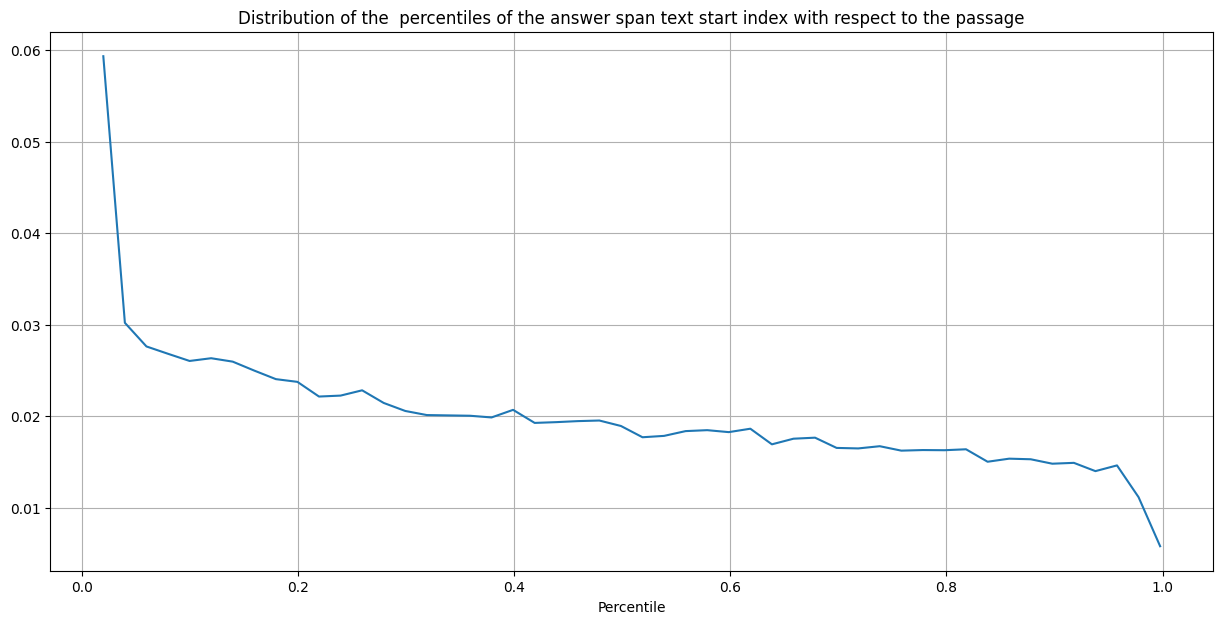

In [25]:
plot_answer_span_text_percentile(train_df)

## [Task 2] Train, Validation and Test splits

In this section the train dataframe is split into an actual train and a validation dataframes.

The split is performed as follows:
1. The random seed is set to $42$ for reproducibility purposes.
2. The train proportion of the actual training dataset to the original dataset is of $0.8$.
3. The train dataframe is shuffled and divided into the two new dataframes making sure that no conversation is split among them.

In [26]:
set_random_seed(42)

In [27]:
from sklearn.model_selection import GroupShuffleSplit
from typing import Tuple

def train_validation_split(df: pd.DataFrame, train_size: int = .8, random_seed: int = 42) \
    -> Tuple[pd.DataFrame, pd.DataFrame]:
    """ Get train and validation dataframes by shuffling and splitting an original dataframe according to a given proportion
    and a specific random seed.
    
    Note: The order of the rows of the same conversation is preserved in the shuffle. Moreover, the conversations are never
    split across the two resulting dataframes.

    Parameters
    ----------
    df : DataFrame
        The dataframe from which the train and validation dataframes are obtained.
    train_size : int, optional
        The proportion of the train split. Defaults to 0.8.
    random_seed : int, optional
        The random seed for the shuffle. Defaults to 42.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: _description_
    """
    # Get indices of train and test rows in the dataframe
    group_shuffle_split = GroupShuffleSplit(n_splits=2, train_size=train_size, random_state=random_seed)
    train_ix, test_ix = next(group_shuffle_split.split(df, groups=df.id))

    train_df = df.loc[train_ix]
    train_df.reset_index(inplace=True, drop=True)
    
    val_df = df.loc[test_ix]
    val_df.reset_index(inplace=True, drop=True)
    
    return train_df, val_df

In [28]:
train_df, val_df = train_validation_split(train_df)

The tail of the obtain dataframe (`train_df`) and the head of the validation dataframe (`val_df`) are shown below to assert that the conversations are not splitted and that their question-answer pairs are still chronologically ordered.

In [29]:
print(f'Train dataframe shape after the split: {train_df.shape}')
train_df.tail()

Train dataframe shape after the split: (85824, 10)


,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
85819,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was a sub?,1405,1427,substitute Xabi Alonso,Xabi Alonso,10,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85820,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,Was it his first game this year?,1415,1467,Xabi Alonso made his first appearance of the ...,Yes,11,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85821,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,What position did the team reach?,1520,1555,Real moved up to third in the table,third,12,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85822,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was ahead of them?,1557,1582,six points behind Barca.,Barca.,13,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85823,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,By how much?,1557,1581,six points behind Barca.,six points,14,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."


In [30]:
print(f'Validation dataframe shape after the split: {val_df.shape}')
val_df.head()

Validation dataframe shape after the split: (21452, 10)


,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,Where was the Auction held?,243,284,Hard Rock Cafe in New York's Times Square,Hard Rock Cafe,1,[]
1,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,How much did they make?,180,210,reaping a total $2 million. \n,$2 million.,2,"[Where was the Auction held?, Hard Rock Cafe]"
2,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,How much did they expected?,292,342,"pre-sale expectations of only $120,000 in sal...","$120,000",3,"[Where was the Auction held?, Hard Rock Cafe, ..."
3,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,WHo buy the Jackson Glove,1295,1365,"Hoffman Ma, who bought the glove on behalf of ...",Hoffman Ma,4,"[Where was the Auction held?, Hard Rock Cafe, ..."
4,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,Where was the buyer of the glove from?,1331,1366,"behalf of Ponte 16 Resort in Macau,",Macau,5,"[Where was the Auction held?, Hard Rock Cafe, ..."


In [31]:
print(f'Train passages count: {len(train_df.groupby(by=["id"]))}')
print(f'Validation passages count: {len(val_df.groupby(by=["id"]))}')

print()

len_tot=len(train_df)+len(val_df)
print(f'Train QaA count: {len(train_df)} \t\t Train QaA ratio: {len(train_df)/len_tot:.2f}')
print(f'Validation QaA count: {len(val_df)} \t Validation QaA ratio: {len(val_df)/len_tot:.2f}')

Train passages count: 5754
Validation passages count: 1439

Train QaA count: 85824 		 Train QaA ratio: 0.80
Validation QaA count: 21452 	 Validation QaA ratio: 0.20


In addition, the train, validation and test dataloaders are provided for future training purposes.

In [32]:
from utils.dataloader_builder import get_dataloader

train_dataloader = get_dataloader(train_df, batch_size=8)
val_dataloader = get_dataloader(val_df)
test_dataloader = get_dataloader(test_df)

## [Task 3] Model definition

In [33]:
#model_name = 'distilroberta-base'          # distil-roberta pretrained model
model_name = 'prajjwal1/bert-tiny'          # tiny-bert pretrained model

use_history=False
seed = 1337

folder='weigths'
if use_history:
    folder_name = f'{folder}\PQH\seed{seed}'
else:
    folder_name = f'{folder}\PQ\seed{seed}'

In [34]:
from models.model import Model 

set_random_seed(seed)
model = Model(model_name=model_name, device='cuda')

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.

## [Task 4] Question generation with text passage $P$ and question $Q$

In [35]:
i=5
question_sample = [train_df.iloc[i]['question']]
passage_sample = [train_df.iloc[i]['story']]
answer_sample = train_df.iloc[i]['answer']

print(f'Question sample: "{question_sample[0]}"')
print()
print(f'Predicted answer by the model: "{model.generate(passage_sample, question_sample)[0]}"')
print()
print(f'True answer: "{answer_sample}"')

Question sample: "how do scholars divide the library?"

Predicted answer by the model: ") ( ( water water ) water water and water water or or water water or or water water"

True answer: "into periods"


## [Task 5] Question generation with text passage $P$, question $Q$ and dialogue history $H$

In [36]:
question_sample = [train_df.iloc[5]['question']]
passage_sample = [train_df.iloc[5]['story']]
answer_sample = train_df.iloc[5]['answer']
history_sample = [' <sep> '.join(train_df.iloc[5]['history'])]

print(f'Question sample: "{question_sample[0]}"')
print()
print(f'Predicted answer by the model: "{model.generate(passage_sample, question_sample, history=history_sample)[0]}"')
print()
print(f'True answer: "{answer_sample}"')

Question sample: "how do scholars divide the library?"

Predicted answer by the model: ") ( ( water water ) water water and water water or or water water or or water water"

True answer: "into periods"


## [Task 6] Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

In [37]:
try:
    checkpoint = torch.load(f"{folder_name}\\{model_name.replace('/','_')}.pth")
    loss_history = checkpoint['loss_history']
    val_loss_history = checkpoint['val_loss_history']
    opt_state_dict=checkpoint['opt_state_dict']
    model.load_state_dict(checkpoint['model_state_dict'])
    print('Loaded saved files')
except:
    loss_history=None
    val_loss_history=None
    opt_state_dict=None
    print('Unable to load saved files, default initialization')

Unable to load saved files, default initialization


In [38]:
from utils.training import train
set_random_seed(seed)
train( train_dataloader=train_dataloader, val_dataloader=val_dataloader, epochs=3,
        model=model, use_history=False, folder_name=folder_name,
        #opt_state_dict = opt_state_dict, 
        loss_history = list(loss_history) if loss_history is not None else None,
        val_loss_history = list(val_loss_history) if loss_history is not None else None,
        steps_validate=0.33, steps_save=0.01, device='cuda')

'epoch: 1/3, 384/10728, 34s 90ms/step, lr: 5e-05, forcing=1, loss: 1.15 3.02'

c:\Users\riccardo\Desktop\NLP-assignment-2\models\encoder_decoder_bertTiny.py:145: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


KeyboardInterrupt: 

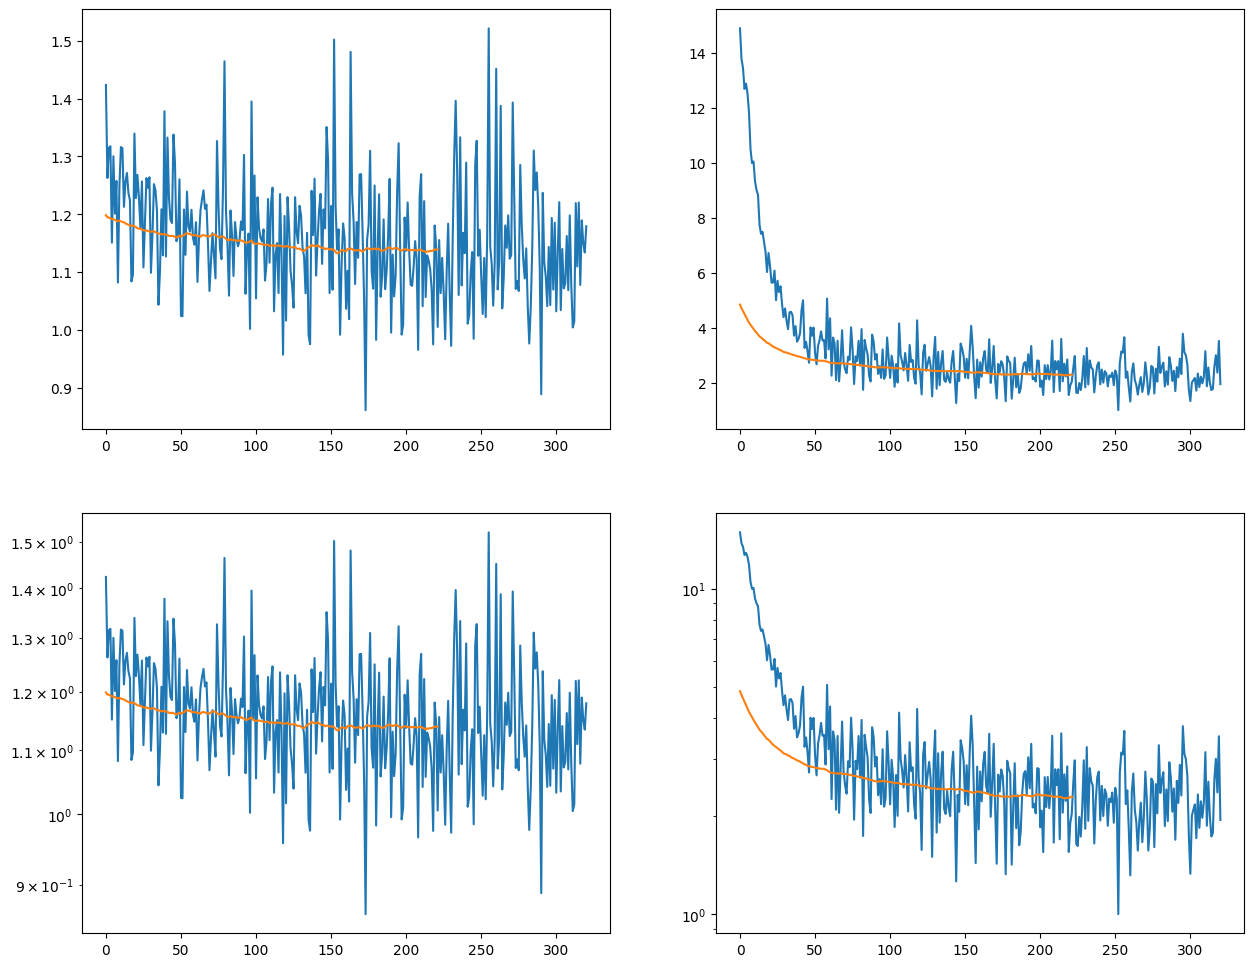

In [39]:
checkpoint = torch.load(f"{folder_name}\\{model_name.replace('/','_')}.pth")
lh = checkpoint['loss_history']
vlh = checkpoint['val_loss_history']

N=100

plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
plt.plot(lh[:,0])
plt.plot(np.convolve(lh[:,0], np.ones(N)/N, mode='valid'))
if len(vlh)>0:
    plt.plot(vlh[:,0],vlh[:,1],'r*')

plt.subplot(2,2,2)
plt.plot(lh[:,1])
plt.plot(np.convolve(lh[:,1], np.ones(N)/N, mode='valid'))
if len(vlh)>0:
    plt.plot(vlh[:,0],vlh[:,2],'r*')

plt.subplot(2,2,3)
plt.plot(lh[:,0])
plt.plot(np.convolve(lh[:,0], np.ones(N)/N, mode='valid'))
if len(vlh)>0:
    plt.plot(vlh[:,0],vlh[:,1],'r*')
plt.yscale('log')

plt.subplot(2,2,4)
plt.plot(lh[:,1])
plt.plot(np.convolve(lh[:,1], np.ones(N)/N, mode='valid'))
if len(vlh)>0:
    plt.plot(vlh[:,0],vlh[:,2],'r*')
plt.yscale('log')

In [40]:
from utils.squad import validate
f1_squad = validate(model, val_dataloader, use_history=False)

KeyboardInterrupt: 

## [Task 7] Error Analysis

Load weights

In [41]:
from models.model import Model 

set_random_seed(seed)
model = Model(model_name=model_name, device='cuda')

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.

In [42]:
checkpoint = torch.load(f"{folder_name}\\{model_name.replace('/','_')}.pth")
loss_history = checkpoint['loss_history']
val_loss_history = checkpoint['val_loss_history']
opt_state_dict=checkpoint['opt_state_dict']
model.load_state_dict(checkpoint['model_state_dict'])
print('Loaded saved files')

Loaded saved files


In [43]:
grouped_test_df = test_df.groupby(by=['source'])
print(f'Number of sources: {len(grouped_test_df)}')

Number of sources: 5


In [45]:
from utils.error_analysis import get_worst_answers, show_worst_errors, plot_token_importances

sources_statistics_dict = dict()
for source, df_source in grouped_test_df:
    sources_statistics_dict[source] = get_worst_answers(model, df_source, False)

100%|██████████| 101/101 [00:37<00:00,  2.68it/s]


In [46]:
print(f'Source names: {"; ".join(sources_statistics_dict.keys())}.')

Source names: cnn; gutenberg; mctest; race; wikipedia.


CNN

In [47]:
show_worst_errors('cnn', sources_statistics_dict)

* Passage: "(CNN) -- Lionel Messi is not for sale. 

That was the defiant message from Barcelona's new president..."
* Question: "A Barcelona member launched a case against who?"
* Gold Answer: "Rosell"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "(CNN) -- A 16-year-old Pennsylvania boy is facing murder charges, accused of fatally shooting a cab ..."
* Question: "AND THE LOCATION?"
* Gold Answer: "in the cab"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "(CNN) -- The Japanese coast guard has rescued a British woman on a solo round-the-world trip whose b..."
* Question: "Across what ocean?"
* Gold Answer: "the Pacific"
* Predicted Answer: "yes"
* F1 SQuAD: 0

* Passage: "(CNN) -- For Heather Neroy, it used to be a tedious process: Whenever she came across an interesting..."
* Question: "After that?"
* Gold Answer: "a shared color board"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "(CNN) -- President Barack Obama has nominated his top counterterrorism adviser

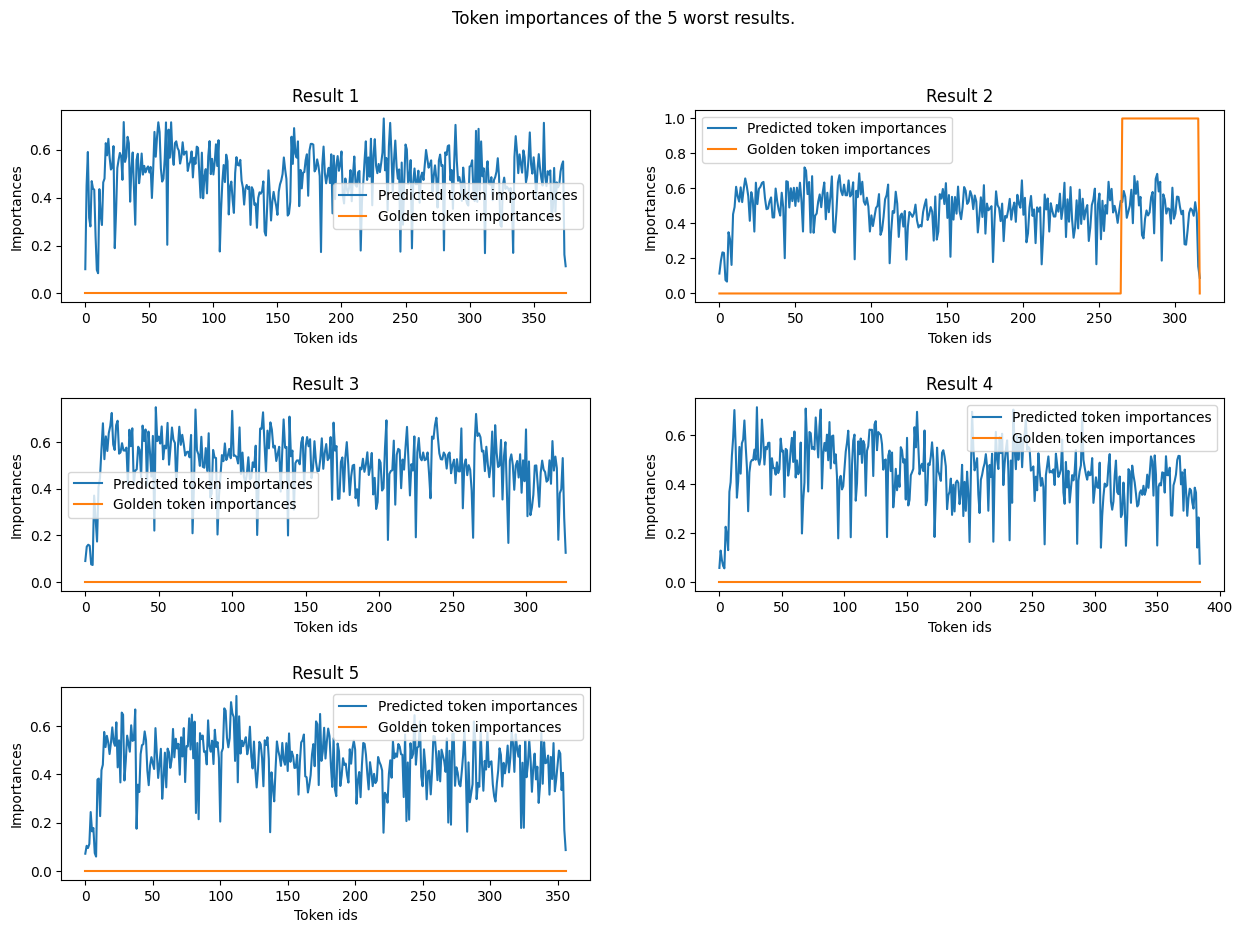

In [49]:
plot_token_importances('cnn', sources_statistics_dict, model)

Gutenberg

In [51]:
show_worst_errors('gutenberg', sources_statistics_dict)

* Passage: "CHAPTER XXIII 

A SLIDE DOWN THE MOUNTAIN SIDE 

"My gracious, Dick! It sure is snowing some now!" 
..."
* Question: "After how many times?"
* Gold Answer: "at least ten"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "CHAPTER VIII 



Five minutes after Paula had left him, punctual to the second, the four telegrams d..."
* Question: "Along with who?"
* Gold Answer: "Thayer"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "CHAPTER NINETEEN. 

A SHOOTING TRIP TO PARADISE ISLE, AND FURTHER DISPLAY OF THE CAPTAIN'S CONTRIVAN..."
* Question: "An insignificant one?"
* Gold Answer: "the main one"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "CHAPTER XII 

THE MEETING OF THE GEE EYES 

When Link Merwell went down again Dave looked at Nat Poo..."
* Question: "And Merwell's?"
* Gold Answer: "Link"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "CHAPTER I. 

"Nerei repandirostrum incurvicervicum pecus." 

A dingy, swashy, splashy afternoon in O..."
* Ques

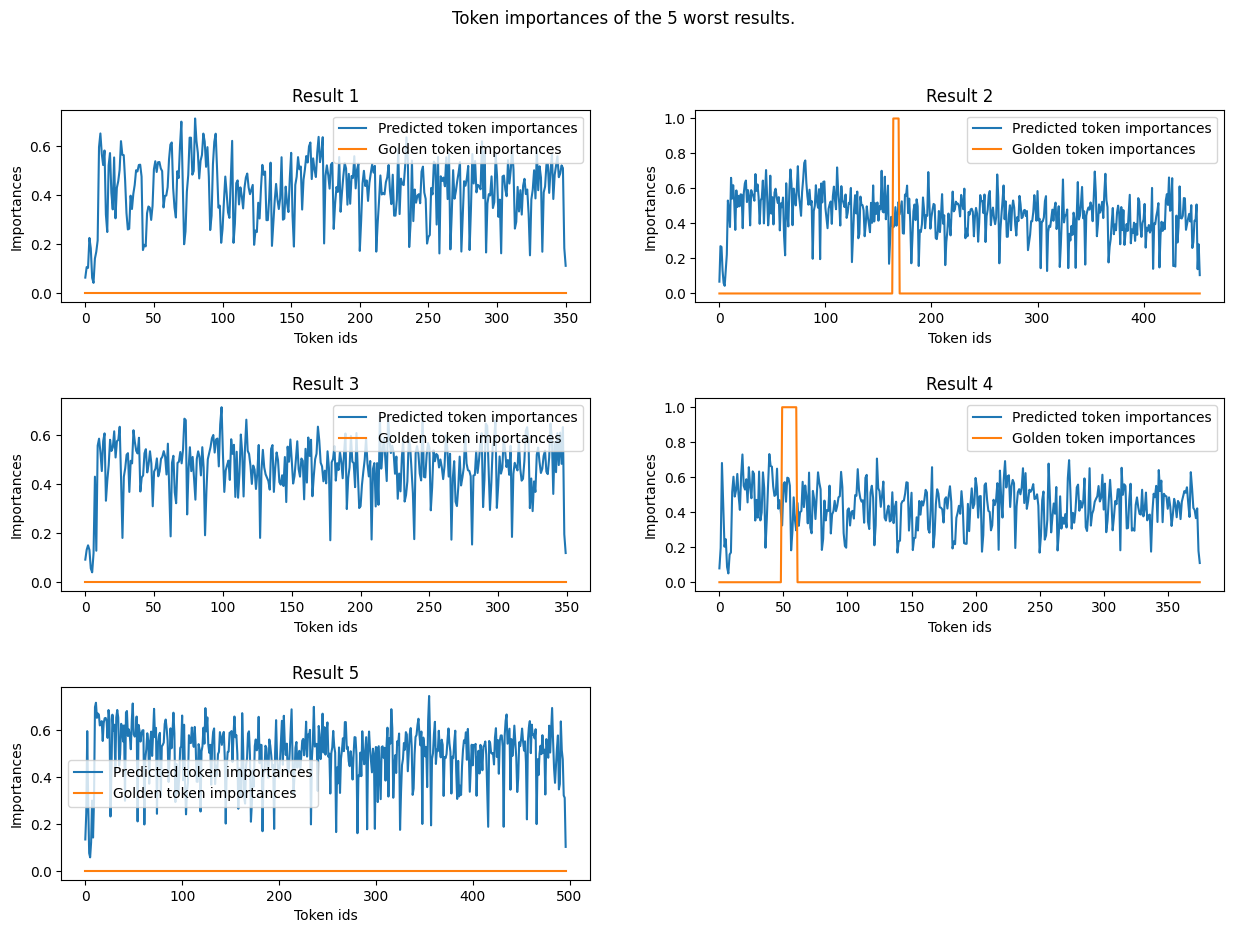

In [52]:
plot_token_importances('gutenberg', sources_statistics_dict, model)

McTest

In [53]:
show_worst_errors('mctest', sources_statistics_dict)

* Passage: "Timmy had the best grandmother ever. She was very nice because she would always help Timmy when he n..."
* Question: "About who?"
* Gold Answer: "his grandfather"
* Predicted Answer: "yes"
* F1 SQuAD: 0

* Passage: "My puppy is a boy puppy. His name is Snow. He is white like snow. Snow has a dog house. It is blue. ..."
* Question: "Am I sad to see him?"
* Gold Answer: "no"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "There once was a boy named John who was a good superhero. He thought he was a superhero, at least. H..."
* Question: "And then?"
* Gold Answer: "she dared him to lick a worm she found on the sidewalk"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "Jenny loves singing. But her baby sister is crying so loud that Jenny can't hear herself, so she was..."
* Question: "And what was the first thing she tried?"
* Gold Answer: "She played with her."
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "Fox was hungry. He was very hungry because he had

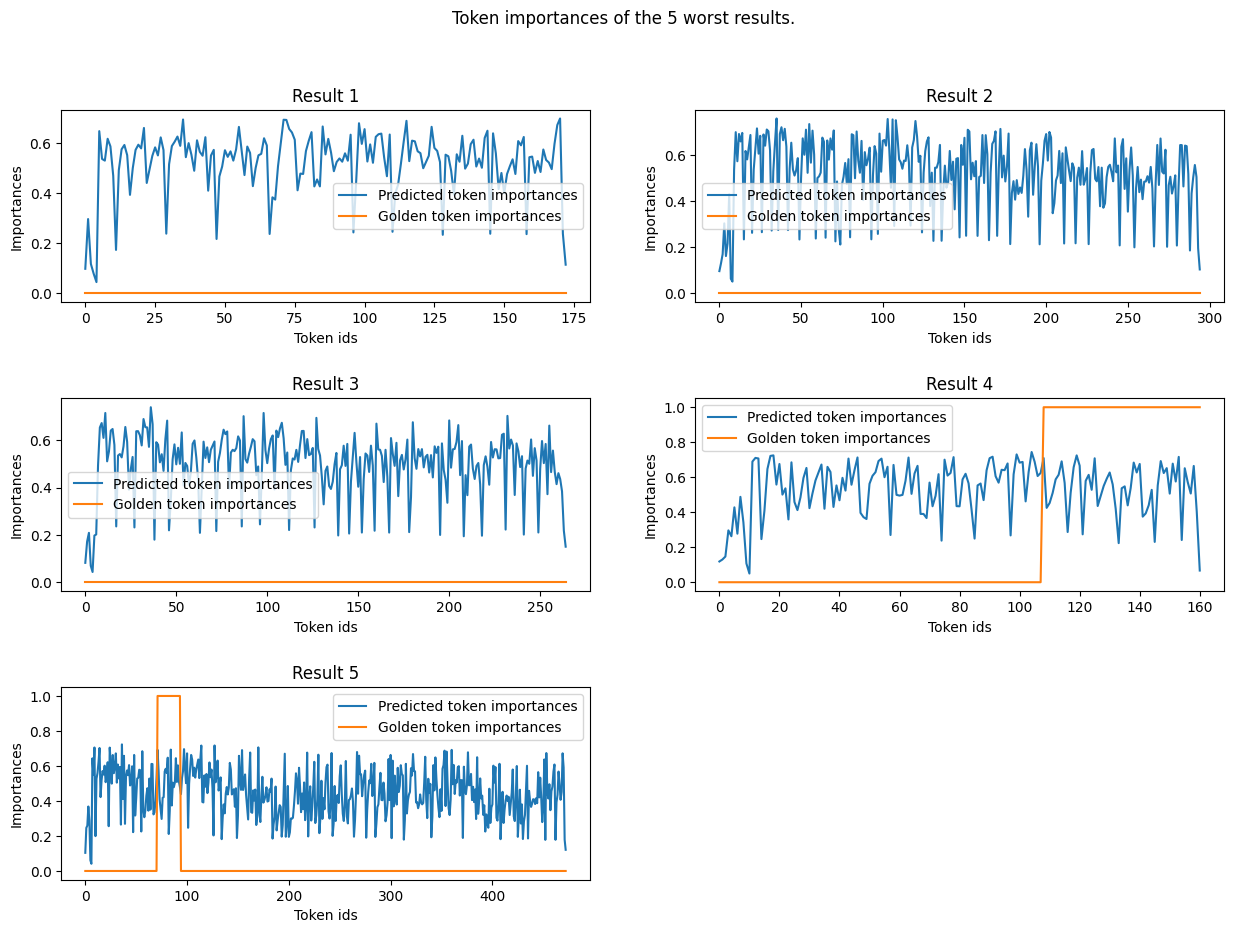

In [54]:
plot_token_importances('mctest', sources_statistics_dict, model)

Race

In [55]:
show_worst_errors('race', sources_statistics_dict)

* Passage: "Lin Xiao, 21, a student at Guangdong University, has a big family - her two parents, a younger broth..."
* Question: "According to the new policy, how many children are now allowed?"
* Gold Answer: "two"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "Time was running out, and Mark Dickinson wasn't sure whether he'd get to see his dying 2-year-old gr..."
* Question: "According to what publication?"
* Gold Answer: "Aurora Sentinel"
* Predicted Answer: "yes"
* F1 SQuAD: 0

* Passage: ""It's 8:15 on a Sunday morning," said the officer, Tidwell, "and this sort of thing seems an unlikel..."
* Question: "According to whom?"
* Gold Answer: "Mrs. Fern."
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "Throughout time, people have loved music for its ability to transport them into a world of rhythm an..."
* Question: "According to whom?"
* Gold Answer: "Garcia's mom"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: ""It's 8:15 on a Sunday morning," said the officer

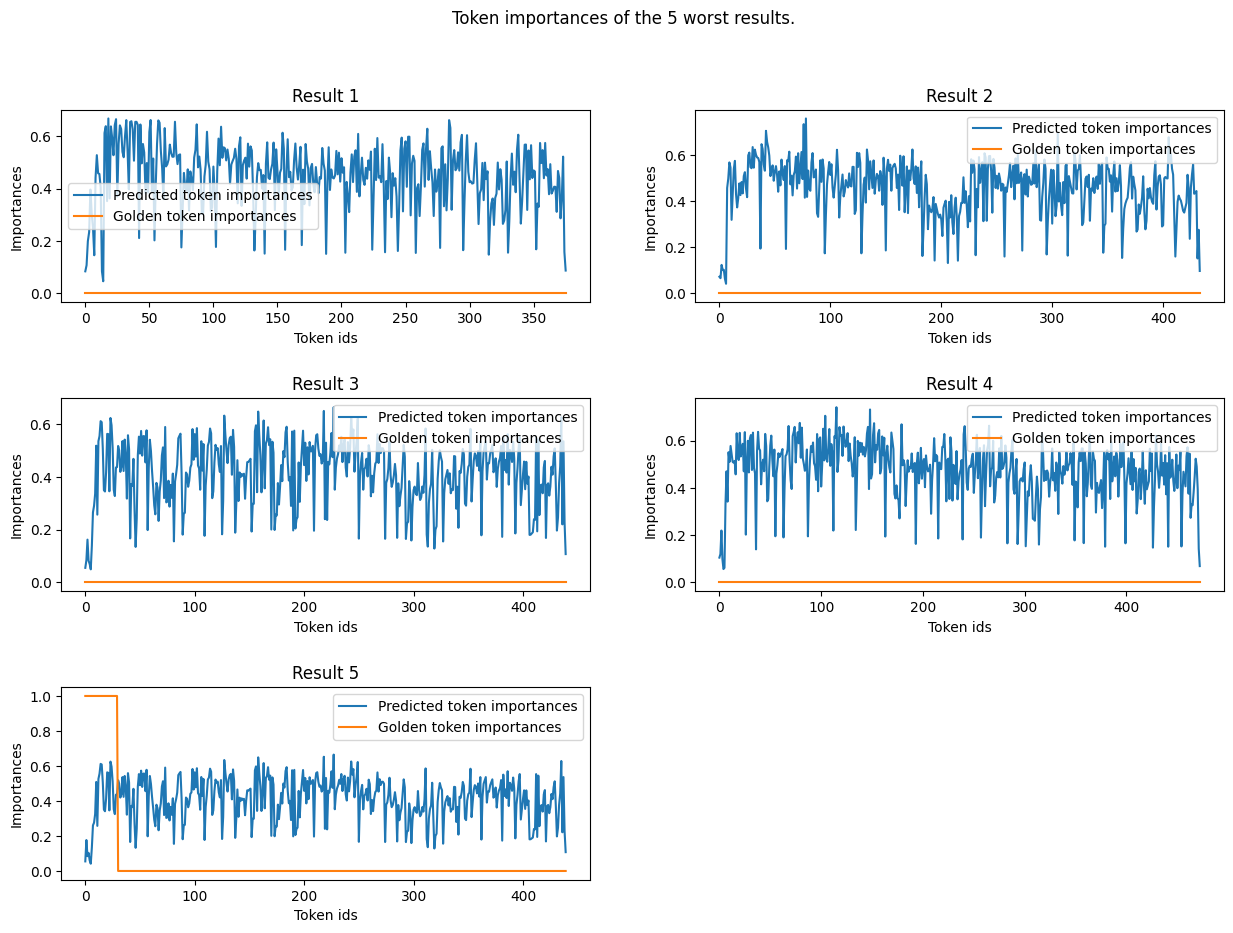

In [56]:
plot_token_importances('race', sources_statistics_dict, model)

Wikipedia

In [57]:
show_worst_errors('wikipedia', sources_statistics_dict)

* Passage: "Gujarati is an Indo-Aryan language native to the Indian state of Gujarat. It is part of the greater ..."
* Question: "According to what census?"
* Gold Answer: "according to the 2011 census"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "A social class (or, simply, class), as in class society, is a set of subjectively defined concepts i..."
* Question: "Ad another?"
* Gold Answer: "political scientists"
* Predicted Answer: "yes"
* F1 SQuAD: 0

* Passage: "Education is the process of facilitating learning, or the acquisition of knowledge, skills, values, ..."
* Question: "After Rome fell, who was the only preserver of literate scholarship in Western Europe?"
* Gold Answer: "the Catholic Church"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "Germany, officially the Federal Republic of Germany, is a federal parliamentary republic in central-..."
* Question: "After that event, What was the Empire replaced by?"
* Gold Answer: "Weimar Republic."
* Predicted Answer

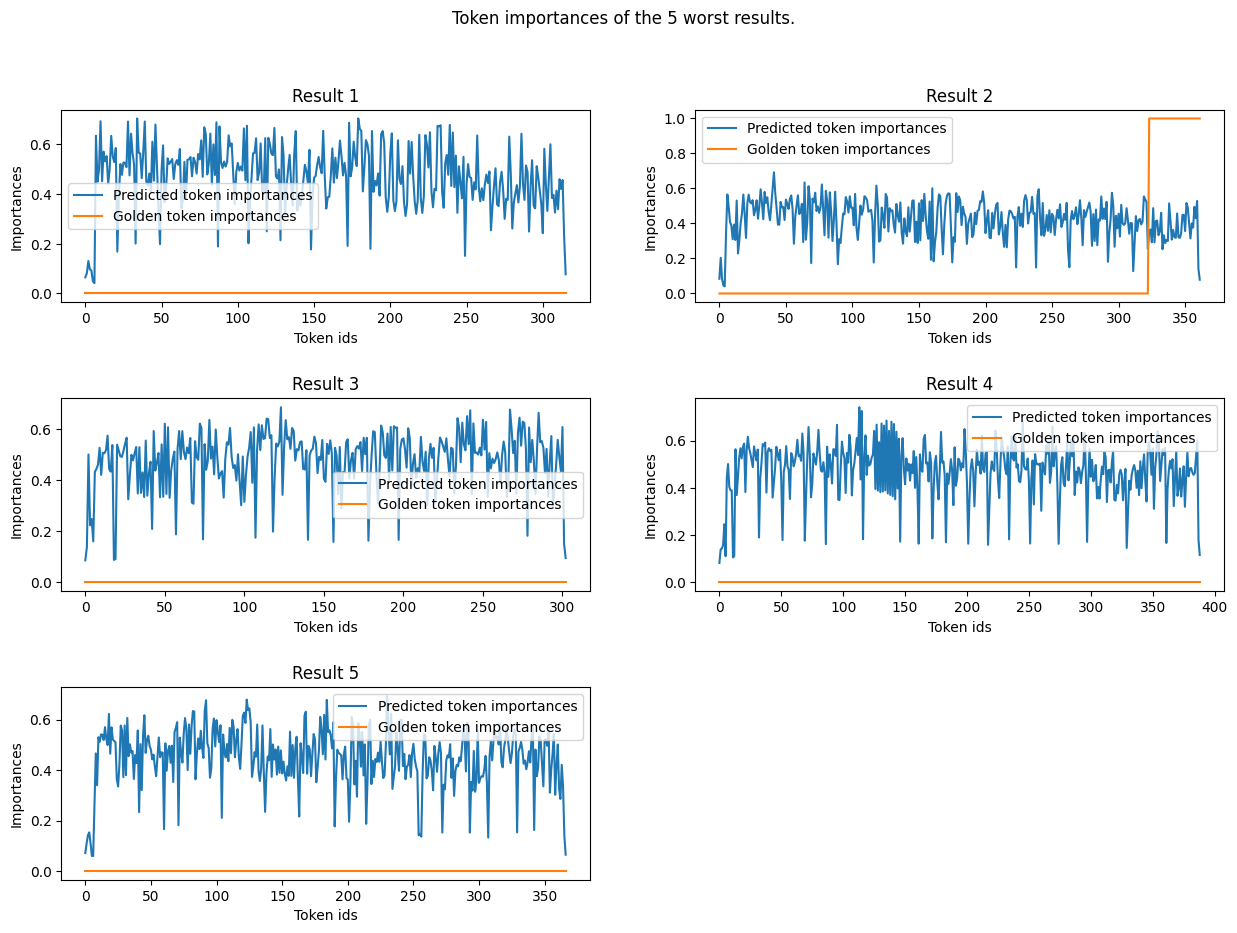

In [58]:
plot_token_importances('wikipedia', sources_statistics_dict, model)